In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.sipm as sipm
import sipm.dataset as ds
from scipy.optimize import curve_fit
from scipy.special import erfc, gamma
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

def compound_poisson(x,n,mu,p):
    k = [int(x_+0.5) for x_ in x]
    ans = []
    for k_ in k:
        if k_==0:
            ans.append(np.exp(-mu))
        else:
            ans_ = 0
            for i in range(1,k_+1):
                ans_ += gamma(k_+1)*gamma(k_)/gamma(i+1)/gamma(i)/gamma(k_-i+1)*(mu*(1-p))**i*p**(k_-i)
            ans.append(n*ans_*np.exp(-mu)/gamma(k_+1))
    return ans

# Top tile calibration (0928 data)

The 0928 datasets use laser pulses as the external trigger.

## Directories

In [4]:
data_dir = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/"
subdir = ['20220928_top_61V_laser_ext/',
          '20220928_top_63V_laser_ext/',
          '20220928_top_65V_laser_ext/',
          '20220928_top_67V_laser_ext/',
          '20220928_top_69V_laser_ext/']

## Process raw data and get:
* charge histograms
* filtered amplitude histograms
* average waveform

In [5]:
datasets = []
for subdir_ in subdir:
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4), samples=2048)
    print(path)
    for i in range(4):
        data.ch[i].read_data(header=False)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_integral(short=1.6, long=5)
        data.ch[i].get_integral_hist(short=[-5e2,5e3,1000], long=[-5e2,5e3,1000])
        data.ch[i].ar_filter(tau=20)
        data.ch[i].get_famp()
        data.ch[i].get_famp_hist(bin=[-1e2,1e3,1000])
        data.ch[i].clear()
    datasets.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_61V_laser_ext/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_63V_laser_ext/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_65V_laser_ext/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_67V_laser_ext/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_69V_laser_ext/


## Plot charge histogram and analyze

Channel 0 Vbd=54.019+/-0.383V slope=42.810+/-1.446
Channel 1 Vbd=54.813+/-0.206V slope=40.831+/-0.795
Channel 2 Vbd=54.241+/-0.224V slope=41.626+/-0.837
Channel 3 Vbd=55.172+/-0.206V slope=43.319+/-0.873


Text(0.5, 0.98, 'Breakdown Voltage (Top)')

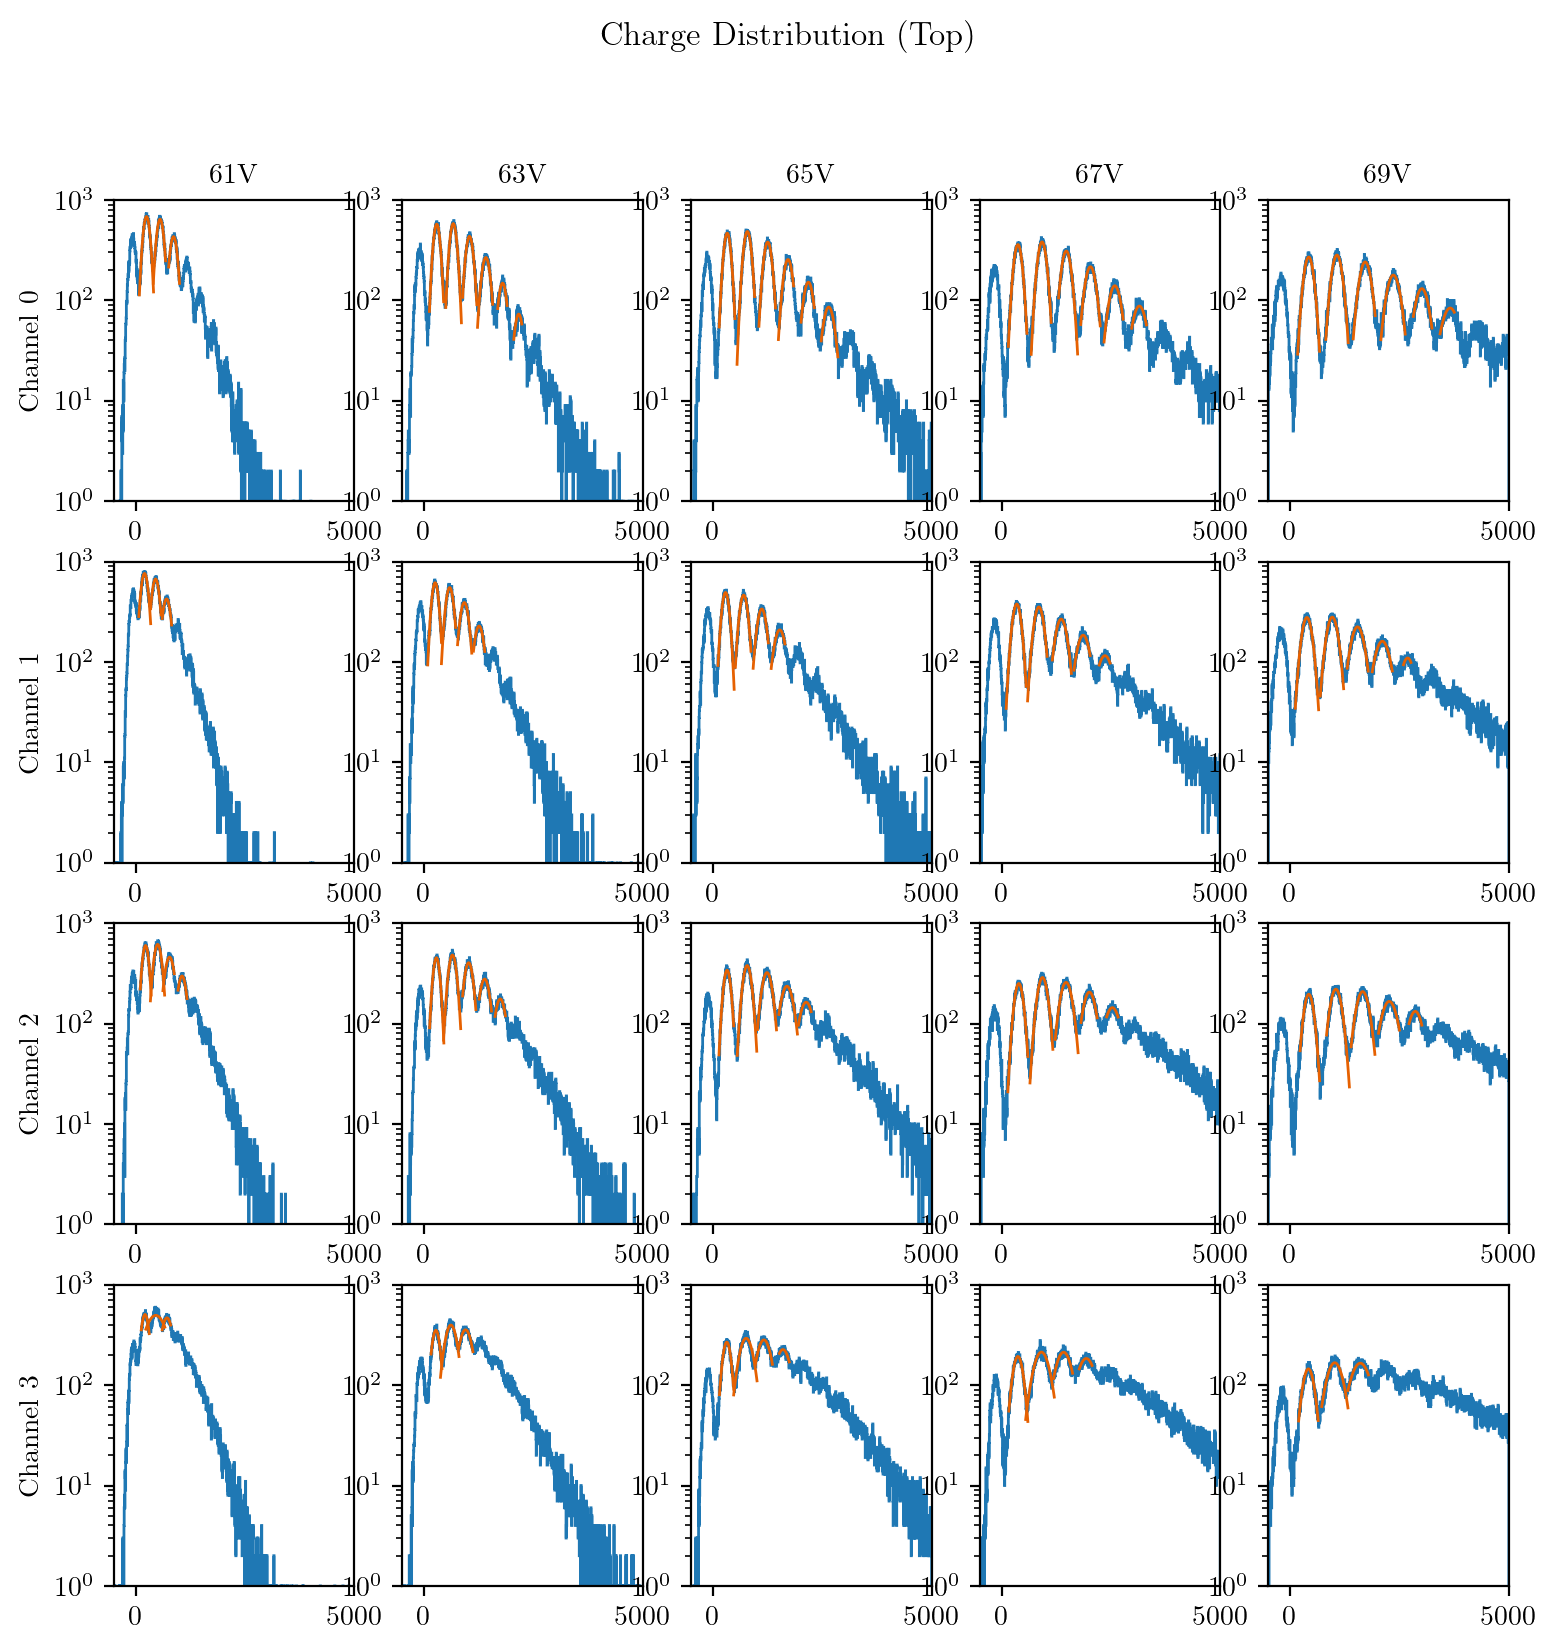

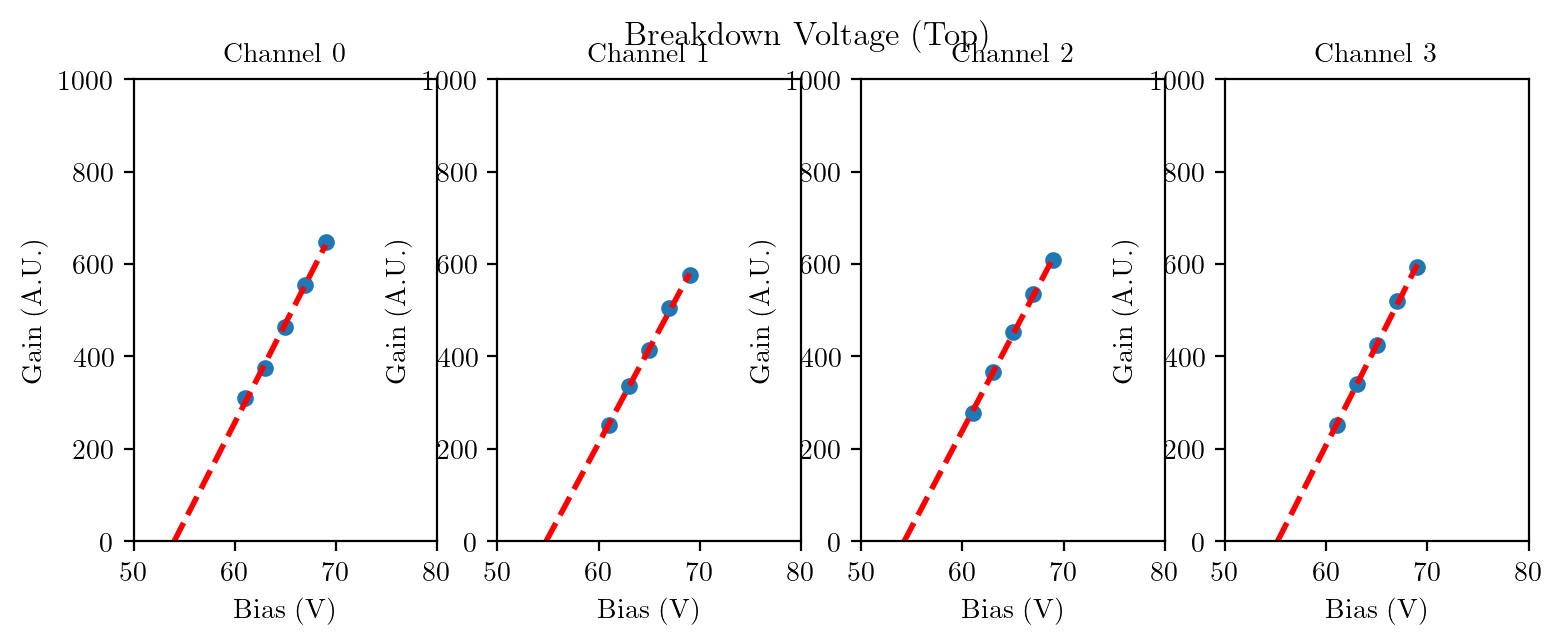

In [6]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
Vbd_charge_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets): 
        #charge histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].integral_short_hist, data.ch[ch].integral_short_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].integral_short_hist_bin[0], data.ch[ch].integral_short_hist_bin[-1])
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        thre = 100 #threshold to remove baseline noise
        peaks,pdict = find_peaks(data.ch[ch].integral_short_hist[thre:], prominence=60, width=15, distance=20)
        #fit pe peaks with Gaussian
        pe_mean = []
        bin_width = data.ch[ch].integral_short_hist_bin[1]-data.ch[ch].integral_short_hist_bin[0]
        peak_range = []
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = bin_width*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = data.ch[ch].integral_short_hist_bin[0] + bin_width*min_bin
            max_x = data.ch[ch].integral_short_hist_bin[0] + bin_width*max_bin
            peak_x = data.ch[ch].integral_short_hist_bin[0] + bin_width*peak_bin
            popt,pcov = curve_fit(gauss, data.ch[ch].integral_short_hist_bin[min_bin:max_bin], data.ch[ch].integral_short_hist[min_bin:max_bin], p0=[data.ch[ch].integral_short_hist[peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(data.ch[ch].integral_short_hist_bin[min_bin:max_bin], gauss(data.ch[ch].integral_short_hist_bin[min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
            pe_mean.append(popt[1])
            peak_range.append([popt[1]-2*popt[2],popt[1]+2*popt[2]])    
        data.ch[ch].set_calibration(integral_peaks=peak_range)
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
        data.ch[ch].set_calibration(gain_integral=popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_integral for data in datasets]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)
        
plt.figure(0)
plt.suptitle('Charge Distribution (Top)')
# plt.savefig('../plots/sipm/charge_histo_top_0928.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Top)')
# plt.savefig('../plots/sipm/gain_bias_charge_top_0928.pdf')

## Plot filtered amplitude histogram and analyze

n=109860 mu=1.931 p=0.082
n=109950 mu=2.127 p=0.132
n=109175 mu=2.280 p=0.171
n=109297 mu=2.356 p=0.228
n=108508 mu=2.420 p=0.288
Channel 0 Vbd=55.363+/-0.079V slope=9.525+/-0.075
n=110079 mu=1.801 p=0.083
n=110814 mu=1.969 p=0.137
n=110684 mu=2.079 p=0.193
n=111574 mu=2.131 p=0.249
n=107632 mu=2.284 p=0.268
Channel 1 Vbd=55.196+/-0.095V slope=8.824+/-0.082
n=110165 mu=2.241 p=0.098
n=110124 mu=2.515 p=0.143
n=109000 mu=2.700 p=0.182
n=108851 mu=2.760 p=0.240
n=108966 mu=2.877 p=0.300
Channel 2 Vbd=55.031+/-0.103V slope=8.870+/-0.088
n=109942 mu=2.498 p=0.094
n=109920 mu=2.753 p=0.149
n=109571 mu=2.920 p=0.192
n=109558 mu=3.039 p=0.253
n=109451 mu=3.164 p=0.307
Channel 3 Vbd=55.153+/-0.083V slope=8.367+/-0.068


Text(0.5, 0.98, 'Breakdown Voltage (Top)')

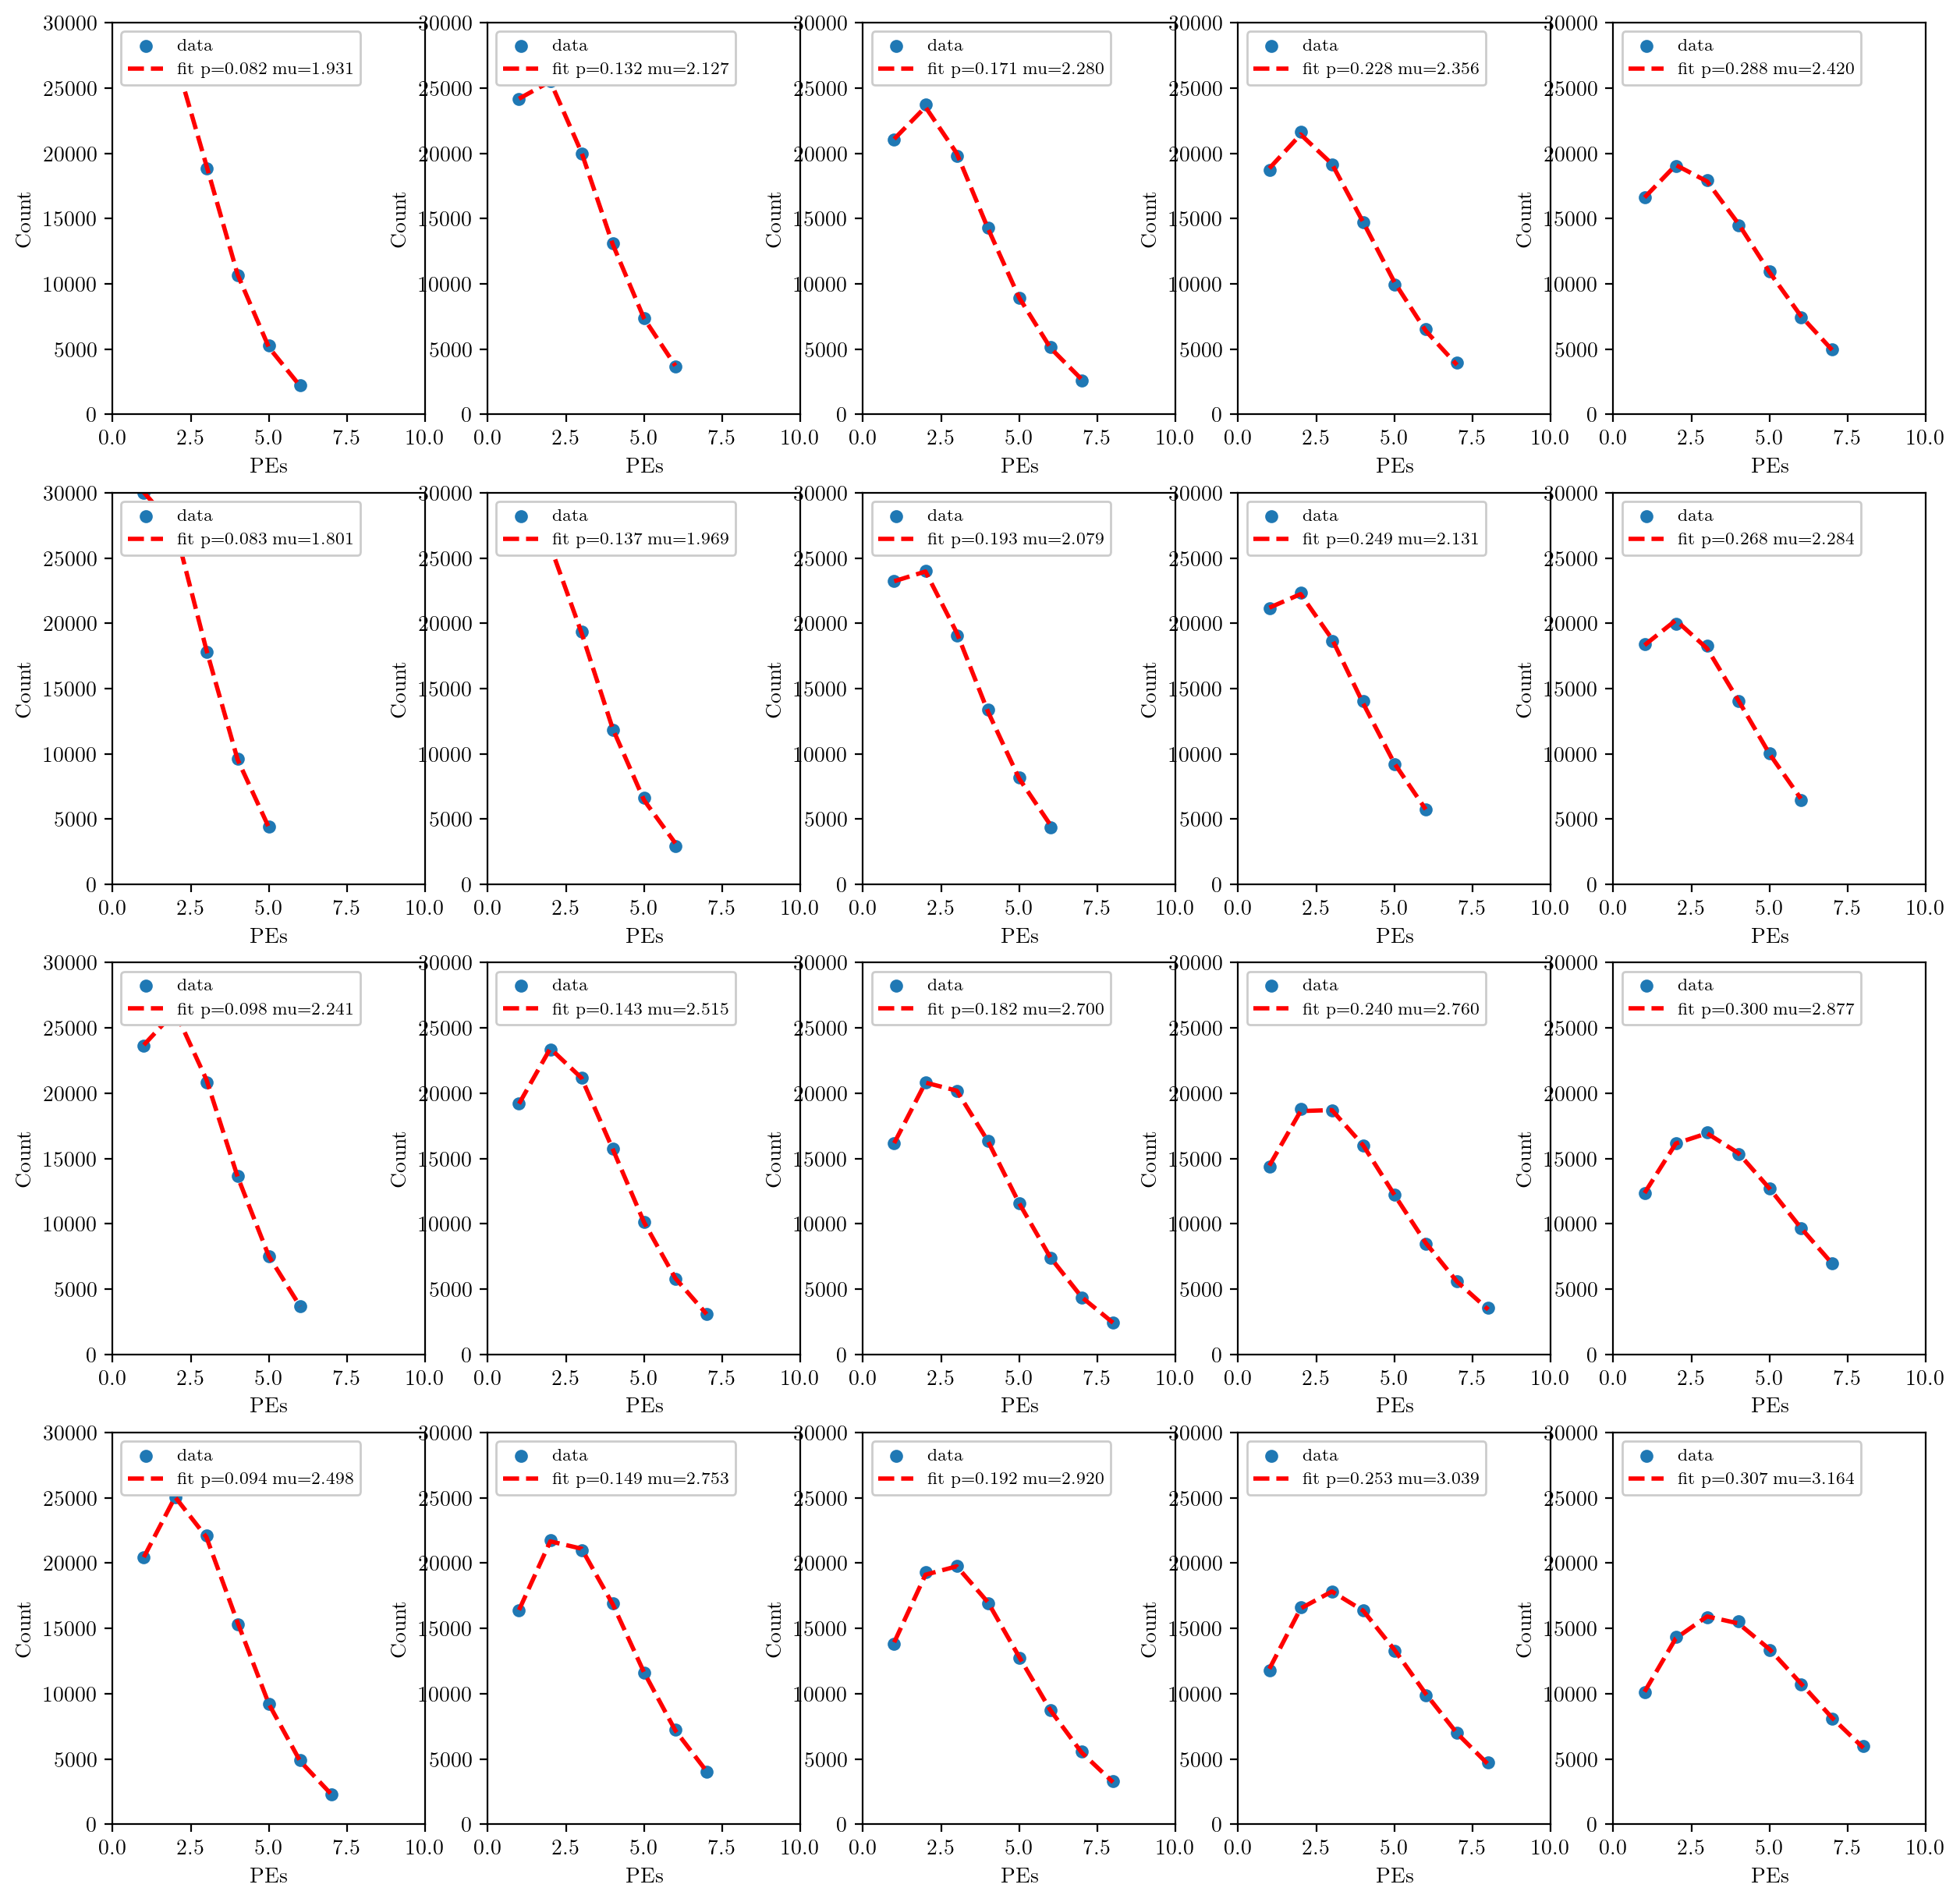

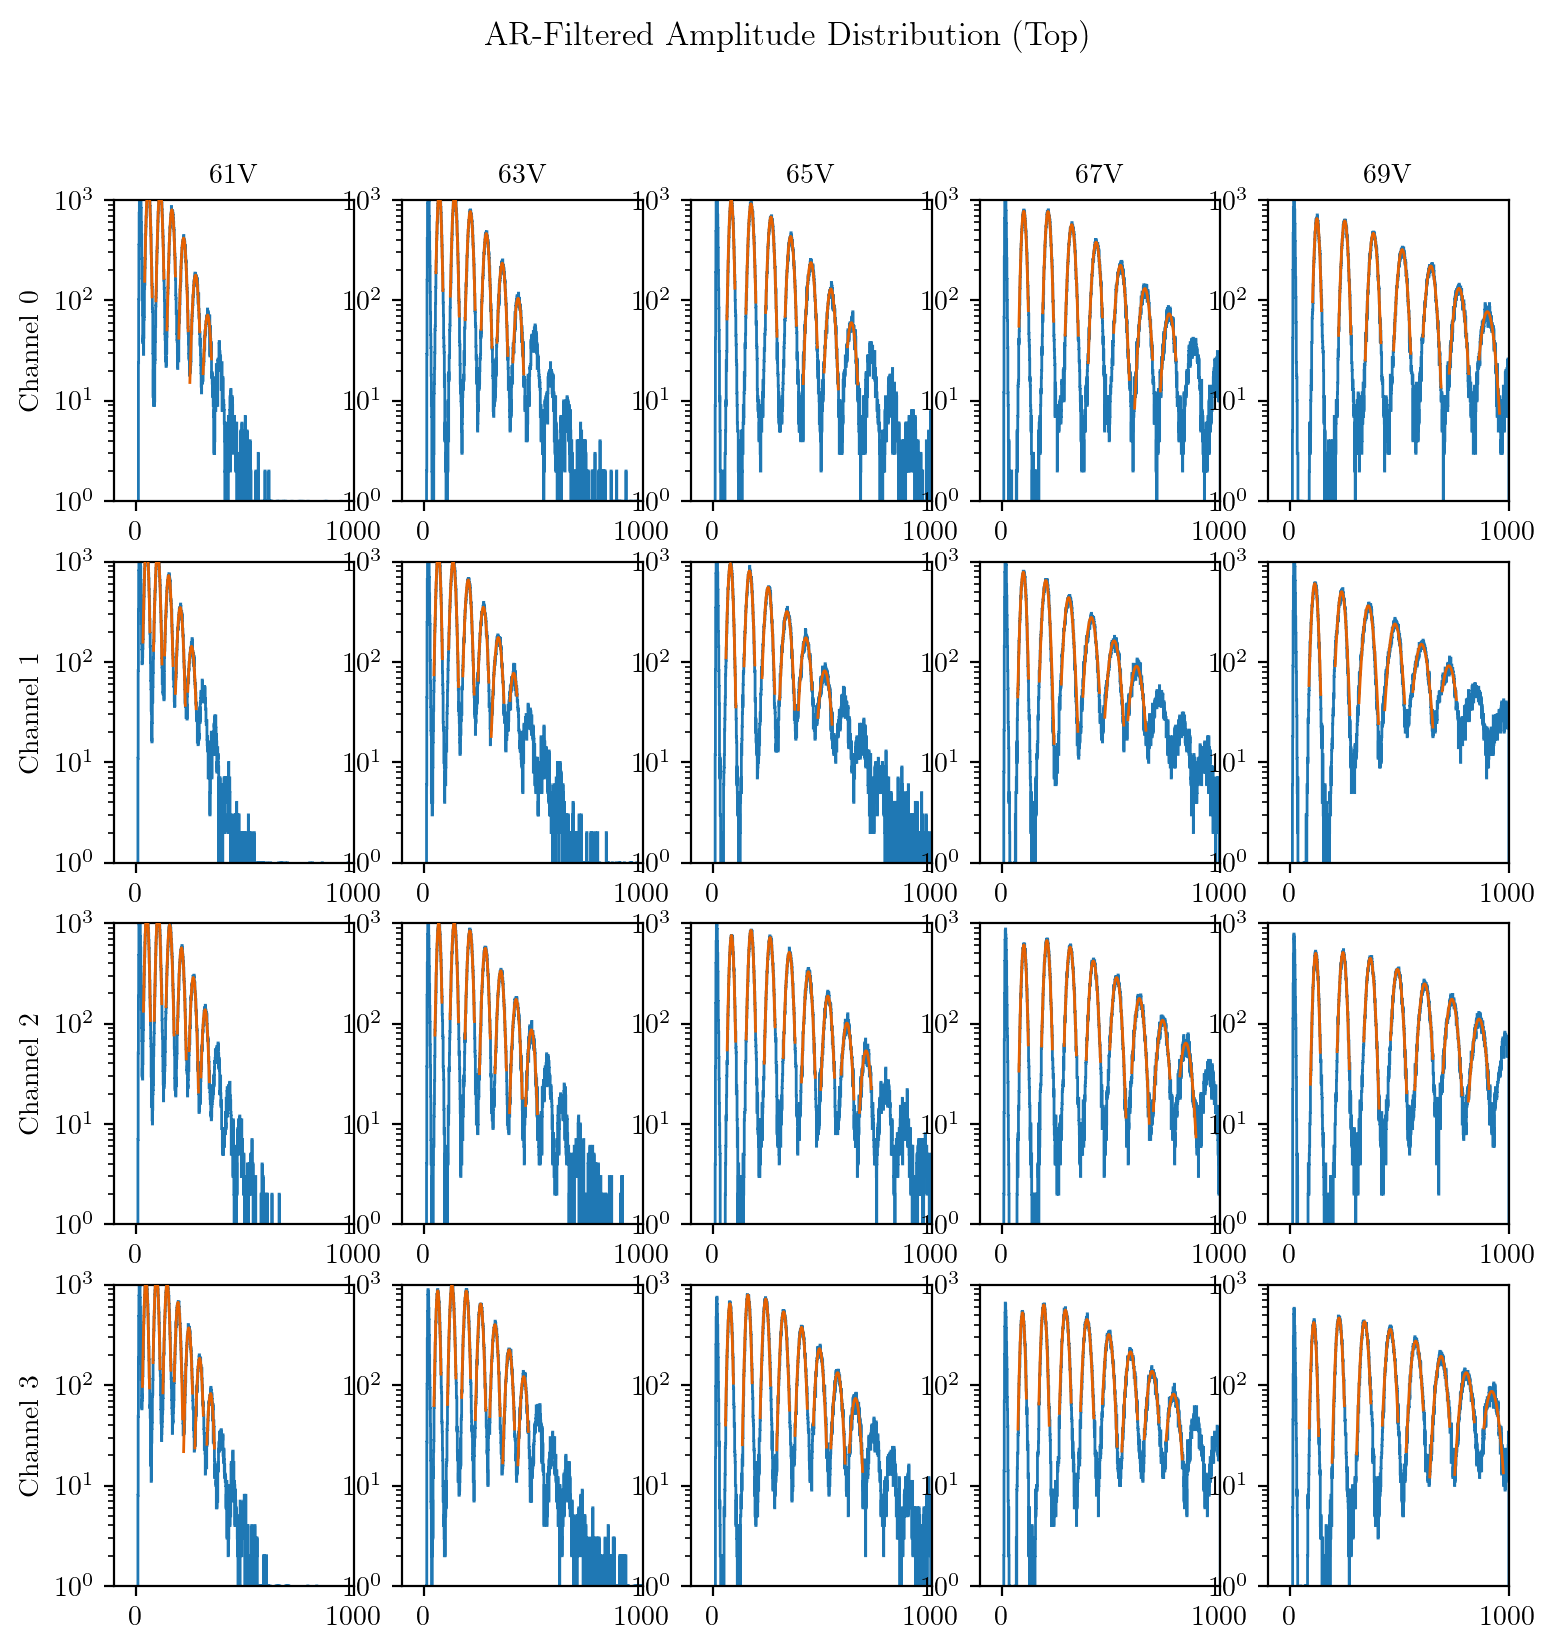

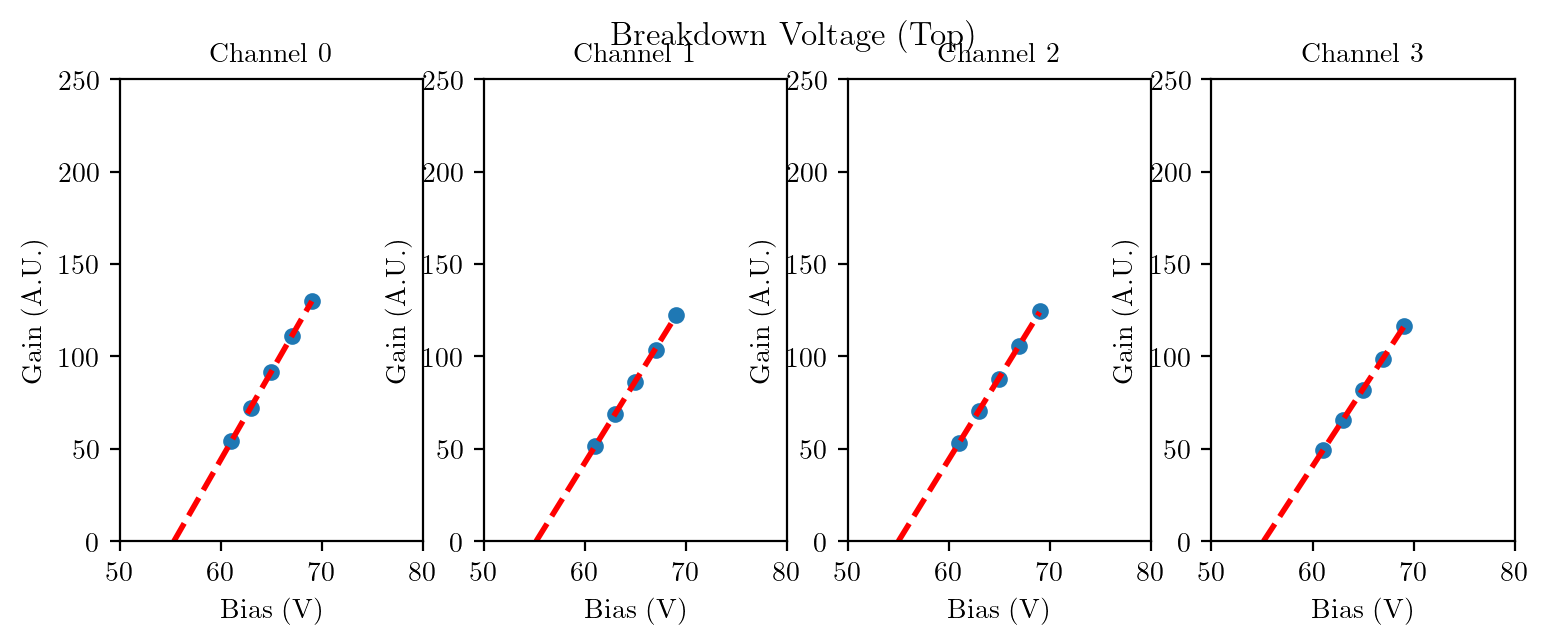

In [7]:
plt.figure(0,figsize=(9,9))#for filtered amplitude histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
plt.figure(2,figsize=(15,15))#for Vinogradov fit
bias = [61, 63, 65, 67, 69]
Vbd_famp_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets):  
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        thre = 30
        peaks,pdict = find_peaks(data.ch[ch].famp_hist[thre:], prominence=60, width=15, distance=20)
        #fit pe peaks with Gaussian
        pe_mean = []
        pe_norm = []
        peak_range = []
        bin_width = data.ch[ch].famp_hist_bin[1]-data.ch[ch].famp_hist_bin[0]
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = bin_width*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = data.ch[ch].famp_hist_bin[0] + bin_width*min_bin
            max_x = data.ch[ch].famp_hist_bin[0] + bin_width*max_bin
            peak_x = data.ch[ch].famp_hist_bin[0] + bin_width*peak_bin
            popt,pcov = curve_fit(gauss, data.ch[ch].famp_hist_bin[min_bin:max_bin], data.ch[ch].famp_hist[min_bin:max_bin], p0=[data.ch[ch].famp_hist[peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(data.ch[ch].famp_hist_bin[min_bin:max_bin], gauss(data.ch[ch].famp_hist_bin[min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
            pe_mean.append(popt[1])
            pe_norm.append(popt[0]*popt[2]*np.sqrt(2*np.pi))
            peak_range.append([popt[1]-2*popt[2],popt[1]+2*popt[2]])
        data.ch[ch].set_calibration(famp_peaks=peak_range)
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
        data.ch[ch].set_calibration(gain_famp=popt[0])
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        plt.scatter(np.arange(1,len(pe_norm)+1), pe_norm, marker='.', label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(pe_norm)+1)), pe_norm, p0=[1e5, 2, 0.3], maxfev=10000)
        print('n={:.0f} mu={:.3f} p={:.3f}'.format(*popt))
        plt.plot(np.arange(1,len(pe_norm)+1), compound_poisson(np.arange(1,len(pe_norm)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
        plt.ylim(0,3e4)
        plt.xlim(0,10)
        plt.xlabel('PEs')
        plt.ylabel('Count')
        plt.legend()

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_famp for data in datasets]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Top)')
# plt.savefig('../plots/sipm/famp_histo_top_0928.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Top)')
# plt.savefig('../plots/sipm/gain_bias_famp_top_0928.pdf')

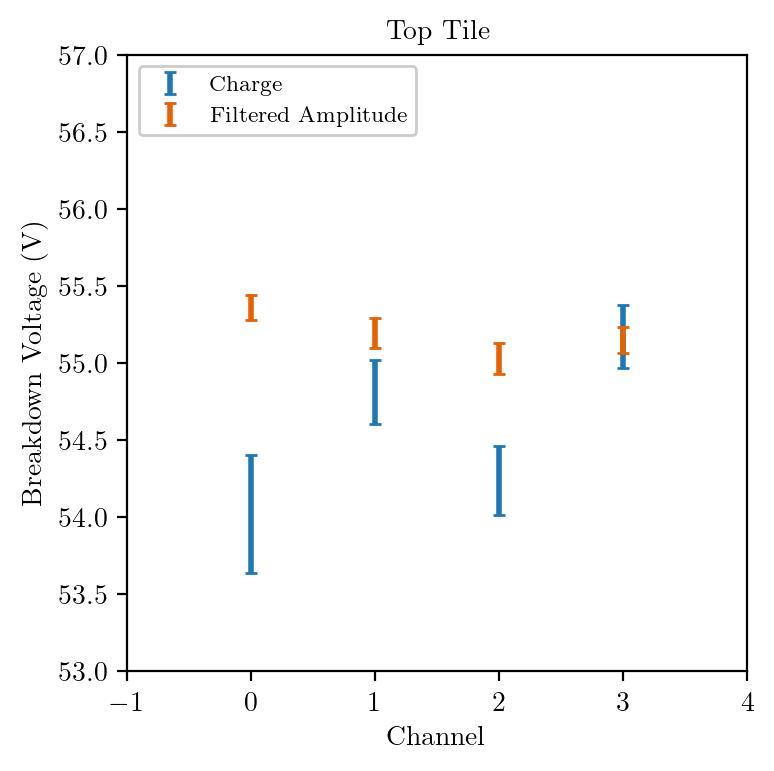

In [8]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_top[:,0], yerr=Vbd_charge_top[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_top[:,0], yerr=Vbd_famp_top[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(53,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Top Tile')
plt.legend()
plt.show()
# plt.savefig('../plots/sipm/vbd_top_0928.pdf')

## Examine after-pulses

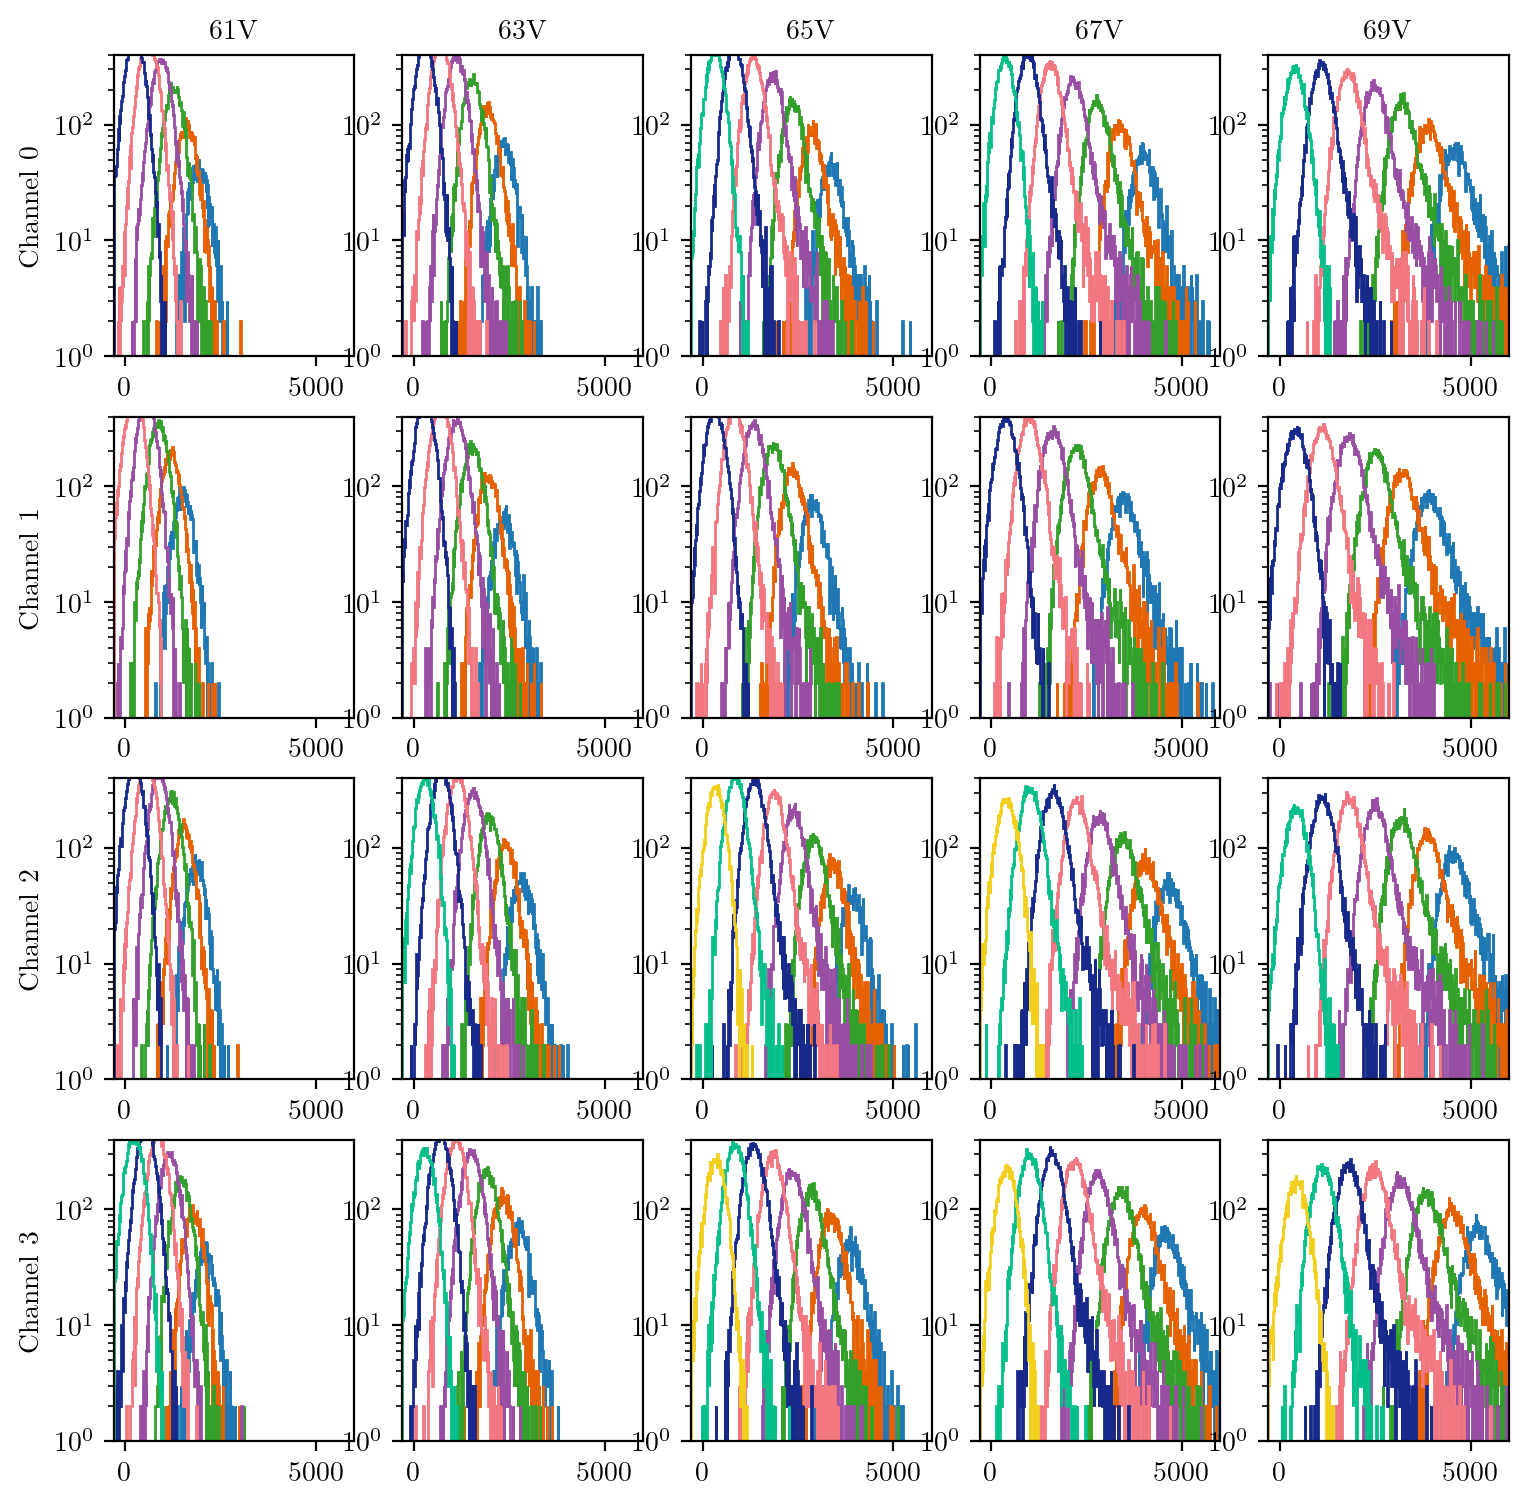

In [13]:
plt.figure(0,figsize=(9,9))

for ch in [0,1,2,3]:
    for i,data in enumerate(datasets):
        data.ch[ch].get_afterpulse_charge(xmin=-300,xmax=6000,nbins=500)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        for j in np.arange(len(data.ch[ch].ap_charge)-1,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,4e2)
        plt.yscale('log')


## SPE average waveform

CH0 61V  A1=1.646+/-0.020 TAU1=0.0727+/-0.0016us A2=2.067+/-0.020 TAU2=0.4239+/-0.0031us
CH0 63V  A1=1.967+/-0.021 TAU1=0.0580+/-0.0012us A2=2.625+/-0.019 TAU2=0.3905+/-0.0024us
CH0 65V  A1=2.344+/-0.027 TAU1=0.0523+/-0.0012us A2=3.394+/-0.025 TAU2=0.3490+/-0.0022us
CH0 67V  A1=3.019+/-0.034 TAU1=0.0467+/-0.0010us A2=4.194+/-0.031 TAU2=0.3206+/-0.0020us
CH0 69V  A1=3.492+/-0.050 TAU1=0.0531+/-0.0013us A2=5.109+/-0.051 TAU2=0.2931+/-0.0022us
Channel 0 Vbd=49.626+/-0.532V slope=21.501+/-0.731
CH1 61V  A1=2.620+/-0.013 TAU1=0.1050+/-0.0010us A2=0.723+/-0.010 TAU2=0.8484+/-0.0109us
CH1 63V  A1=3.441+/-0.016 TAU1=0.1027+/-0.0009us A2=0.955+/-0.014 TAU2=0.7566+/-0.0093us
CH1 65V  A1=4.379+/-0.024 TAU1=0.0929+/-0.0010us A2=1.247+/-0.021 TAU2=0.6623+/-0.0094us
CH1 67V  A1=5.585+/-0.026 TAU1=0.1004+/-0.0009us A2=1.412+/-0.024 TAU2=0.6463+/-0.0090us
CH1 69V  A1=6.097+/-0.037 TAU1=0.0896+/-0.0010us A2=1.935+/-0.037 TAU2=0.5326+/-0.0079us
Channel 1 Vbd=50.923+/-0.842V slope=22.190+/-1.301
CH2 61V 

Text(0.5, 0.98, 'SPE Average Waveform (Top)')

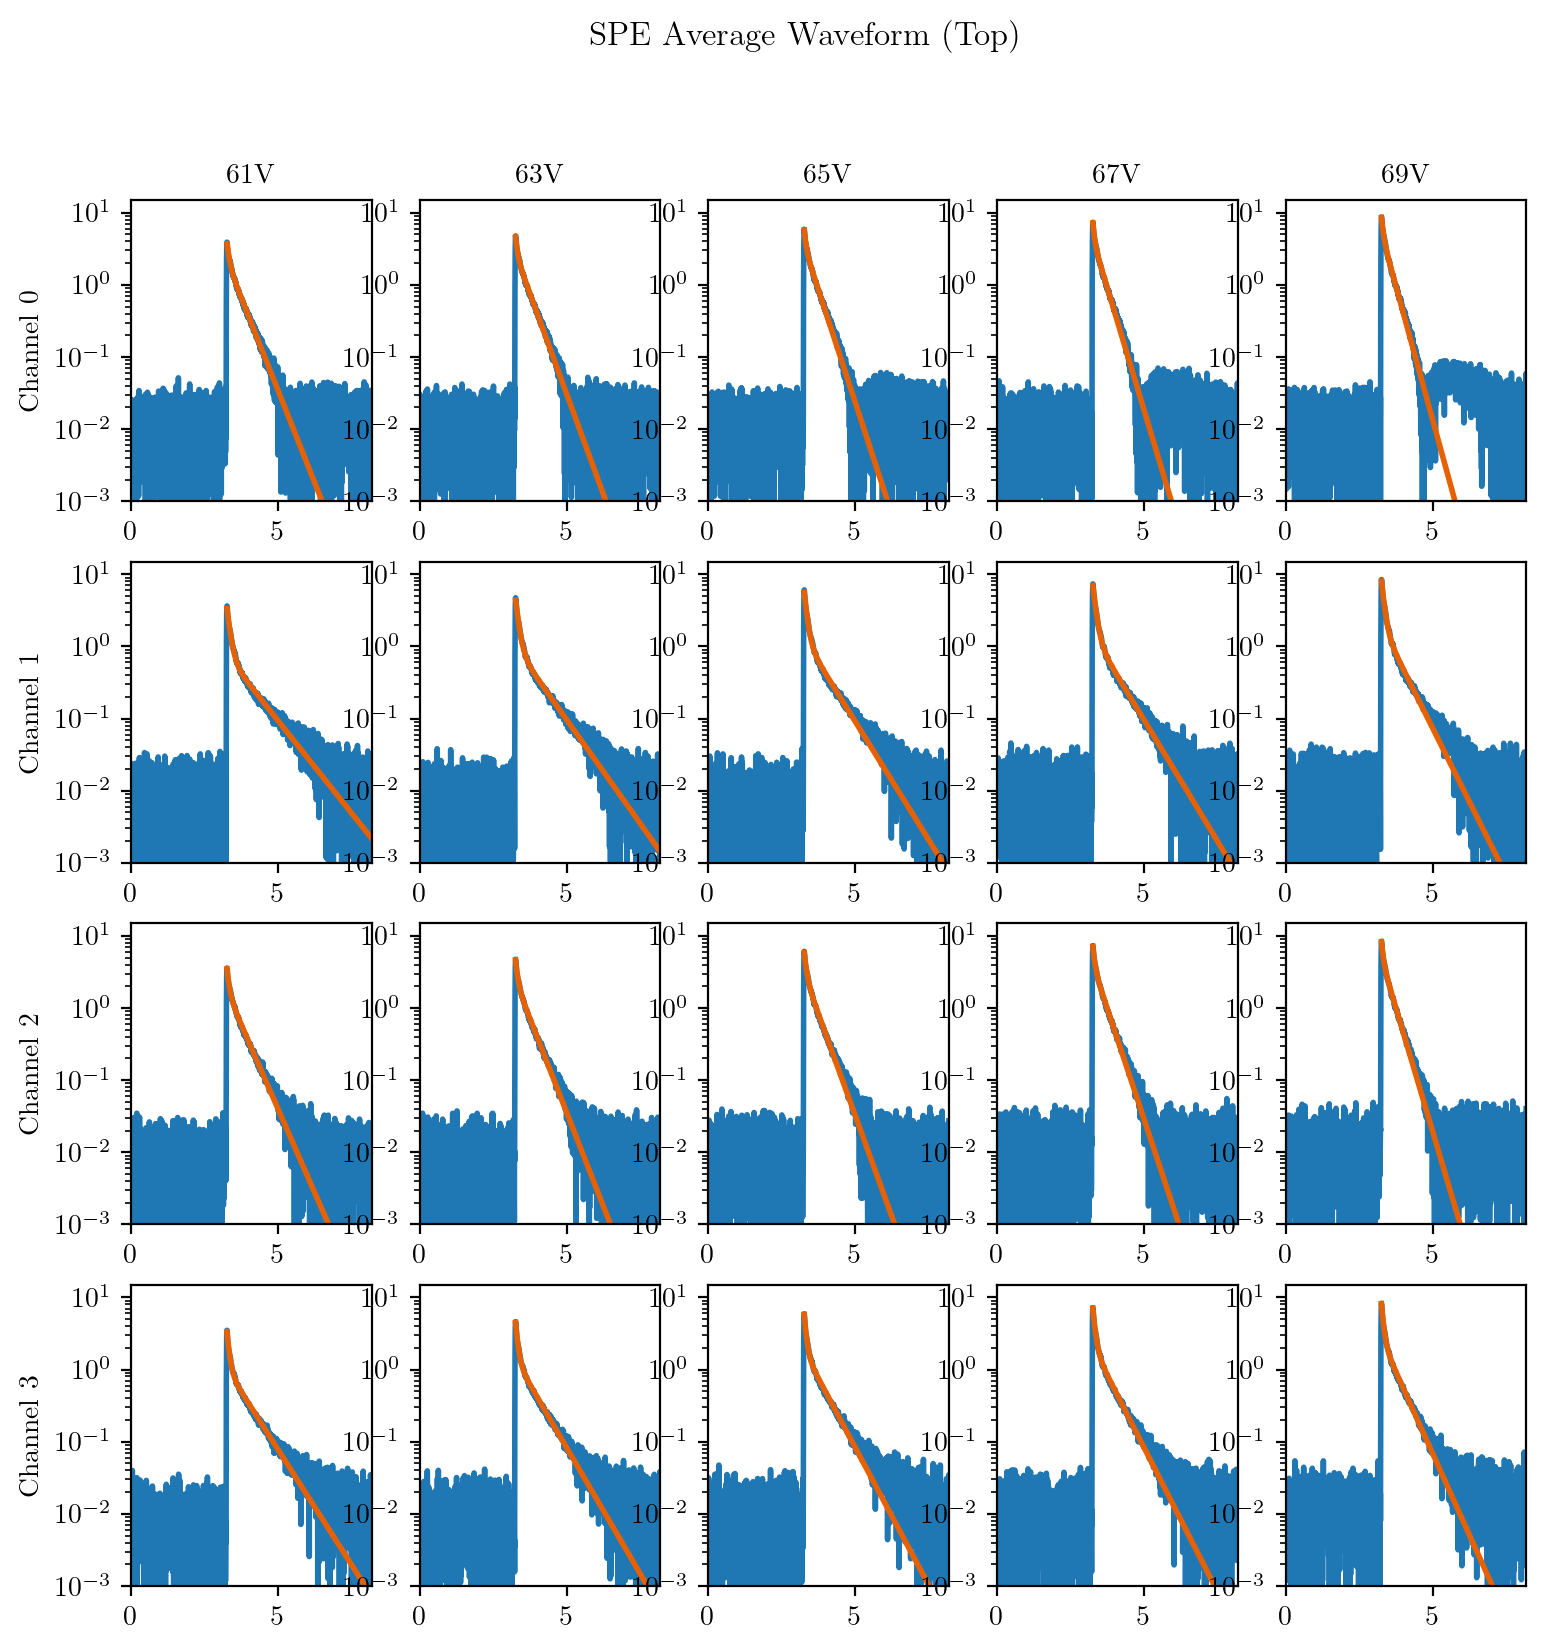

In [10]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
bias = [61, 63, 65, 67, 69]
for ch in [0,1,2,3]:
    spe_integral = []
    for i,data in enumerate(datasets):
        data.ch[ch].get_spe_avgwf()
        data.ch[ch].clear()
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(data.ch[ch].time, abs(data.ch[ch].spe_avgwf))
        err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[data.ch[ch].trigger_position:], data.ch[ch].spe_avgwf[data.ch[ch].trigger_position:], p0=[3,0.08,3,0.5], sigma=[err]*len(data.ch[ch].time[data.ch[ch].trigger_position:]), maxfev=10000)
        plt.plot(data.ch[ch].time[data.ch[ch].trigger_position:], data.ch[ch].get_pulse_shape(data.ch[ch].time[data.ch[ch].trigger_position:],*popt))
        spe_integral.append(popt[0]*popt[1]*250+popt[2]*popt[3]*250)
        print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3])))
        data.ch[ch].set_pulse_pars(a1=[popt[0],np.sqrt(pcov[0,0])], tau1=[popt[1],np.sqrt(pcov[1,1])], a2=[popt[2],np.sqrt(pcov[2,2])], tau2=[popt[3],np.sqrt(pcov[3,3])])
        plt.xlim(data.ch[ch].time[0],data.ch[ch].time[-1])
        plt.ylim(1e-3, 15)
        plt.yscale('log')
    #breakdown voltage fit and plot
    xlin = bias
    ylin = spe_integral
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
plt.suptitle('SPE Average Waveform (Top)')
# plt.savefig('../plots/sipm/spewf_top_0928.pdf')

# Bottome tile calibration (0928 data)

## Directories

In [10]:
data_dir = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/"
subdir = ['20220928_bottom_61V_laser_ext/',
          '20220928_bottom_63V_laser_ext/',
          '20220928_bottom_65V_laser_ext/',
          '20220928_bottom_67V_laser_ext/',
          '20220928_bottom_69V_laser_ext/']

## Process raw data and get:
* charge histograms
* filtered amplitude histograms
* average waveform

In [11]:
datasets = []
for subdir_ in subdir:
    avgwf_ch = []
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4), samples=2048)
    for i in range(4):
        print(data.ch[i].file)
        data.ch[i].read_data(header=False)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_integral(length=1.6)
        data.ch[i].get_integral_hist(min=0, max=5e3, nbins=1000)
        data.ch[i].ar_filter(tau=20)
        data.ch[i].get_ar_filtered_amp()
        data.ch[i].get_famp_hist(min=0, max=1e3, nbins=1000)
        data.ch[i].clear()
    datasets.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_61V_laser_ext/wave0.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 815
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_61V_laser_ext/wave1.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 815
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_61V_laser_ext/wave2.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 815
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_61V_laser_ext/wave3.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 815
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_63V_laser_ext/wave0.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 815
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflect

## Plot charge histogram and analyze

Channel 0 Vbd=54.766+/-0.428V slope=39.327+/-1.584
ch0 gain@60V = 205.82353857375963
Channel 1 Vbd=55.099+/-0.298V slope=41.039+/-1.188
ch1 gain@60V = 201.11478860251896
Channel 2 Vbd=55.224+/-0.144V slope=37.207+/-0.527
ch2 gain@60V = 177.70098280933044
Channel 3 Vbd=54.624+/-0.244V slope=43.592+/-0.989
ch3 gain@60V = 234.3266508247796


/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0.98, 'Breakdown Voltage (Bottom)')

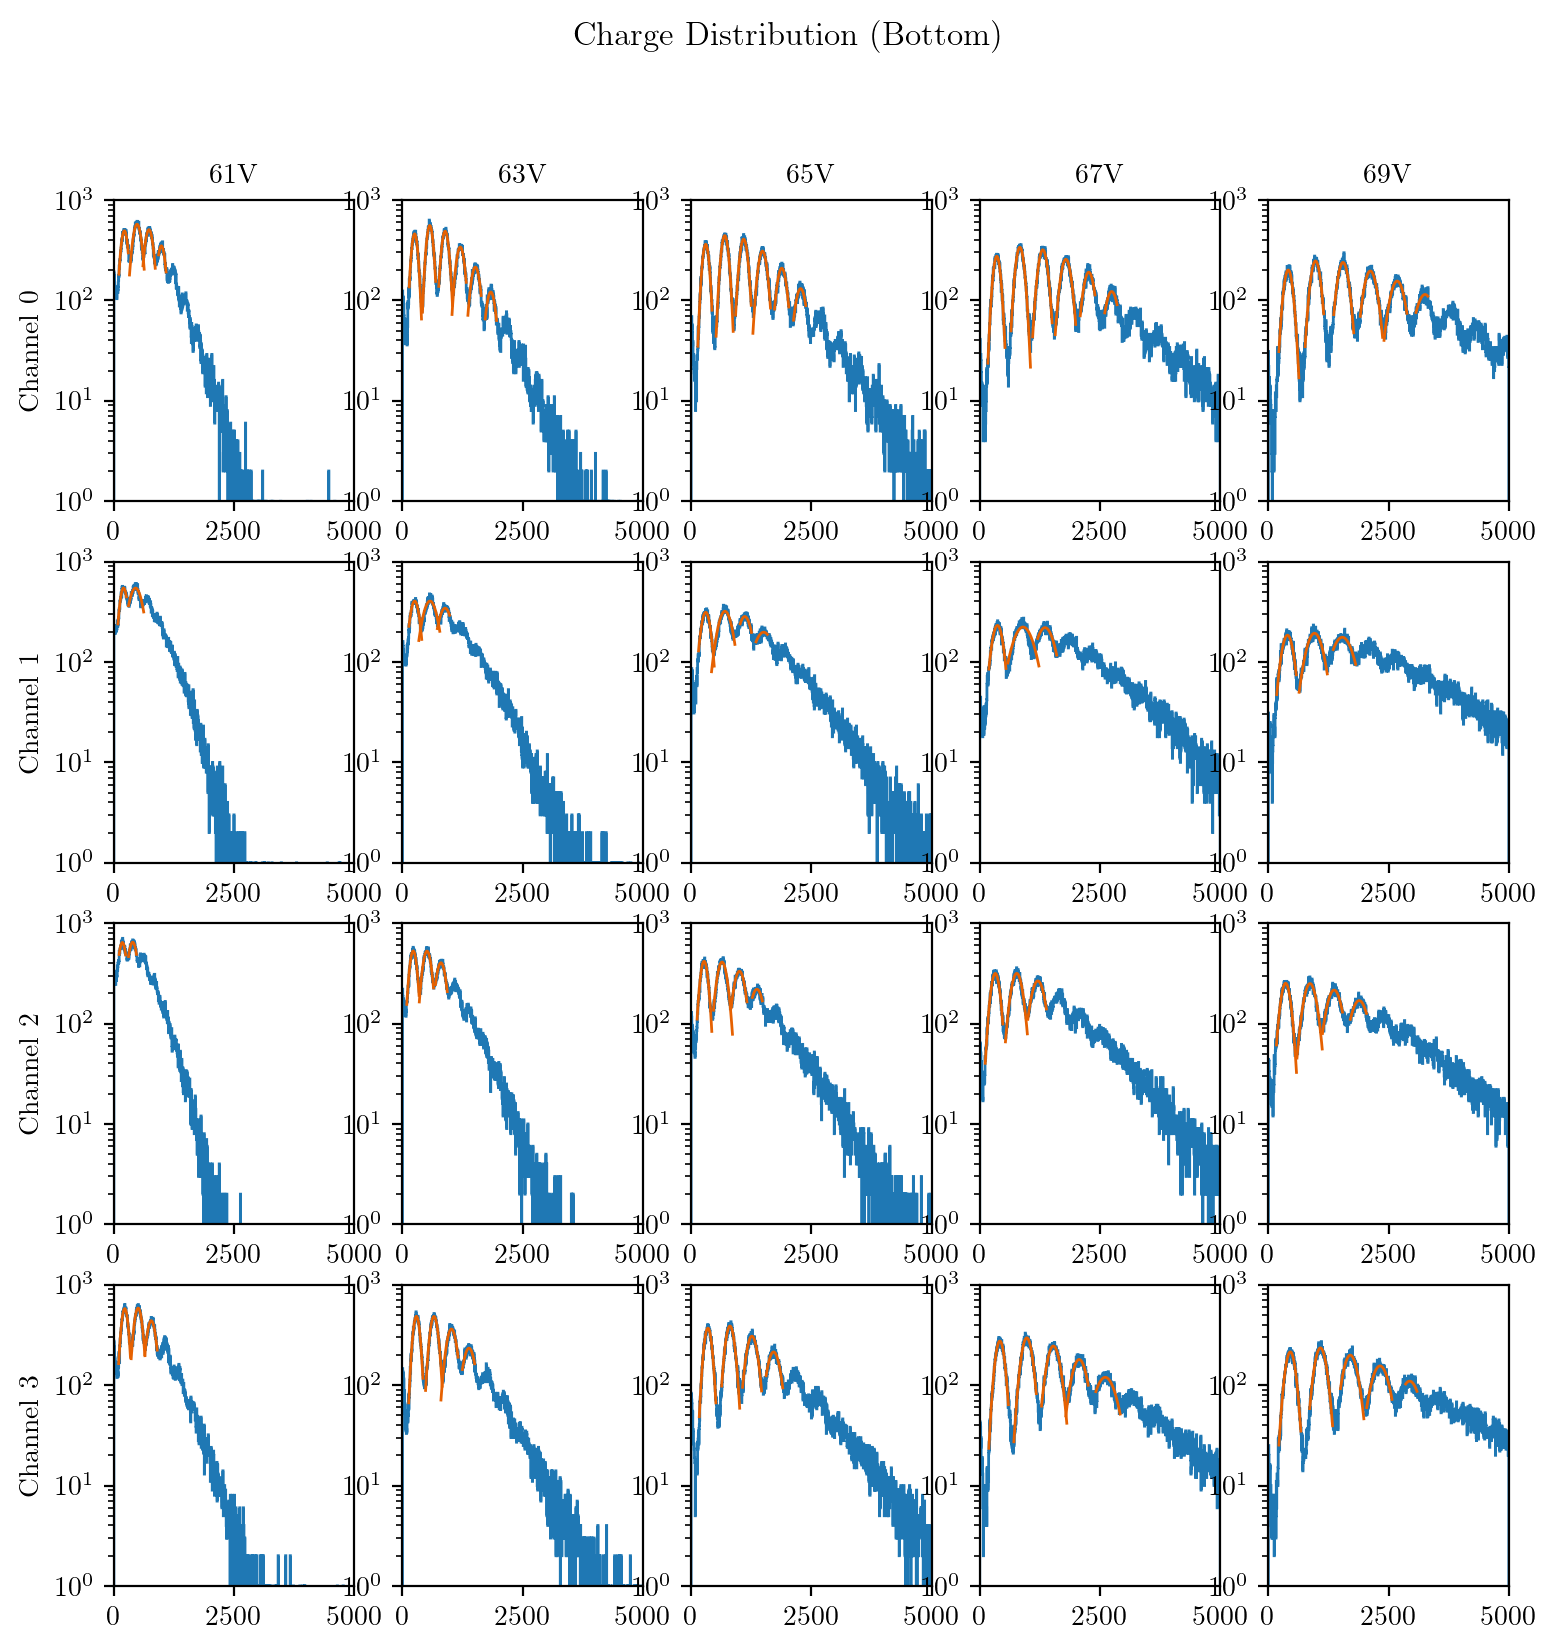

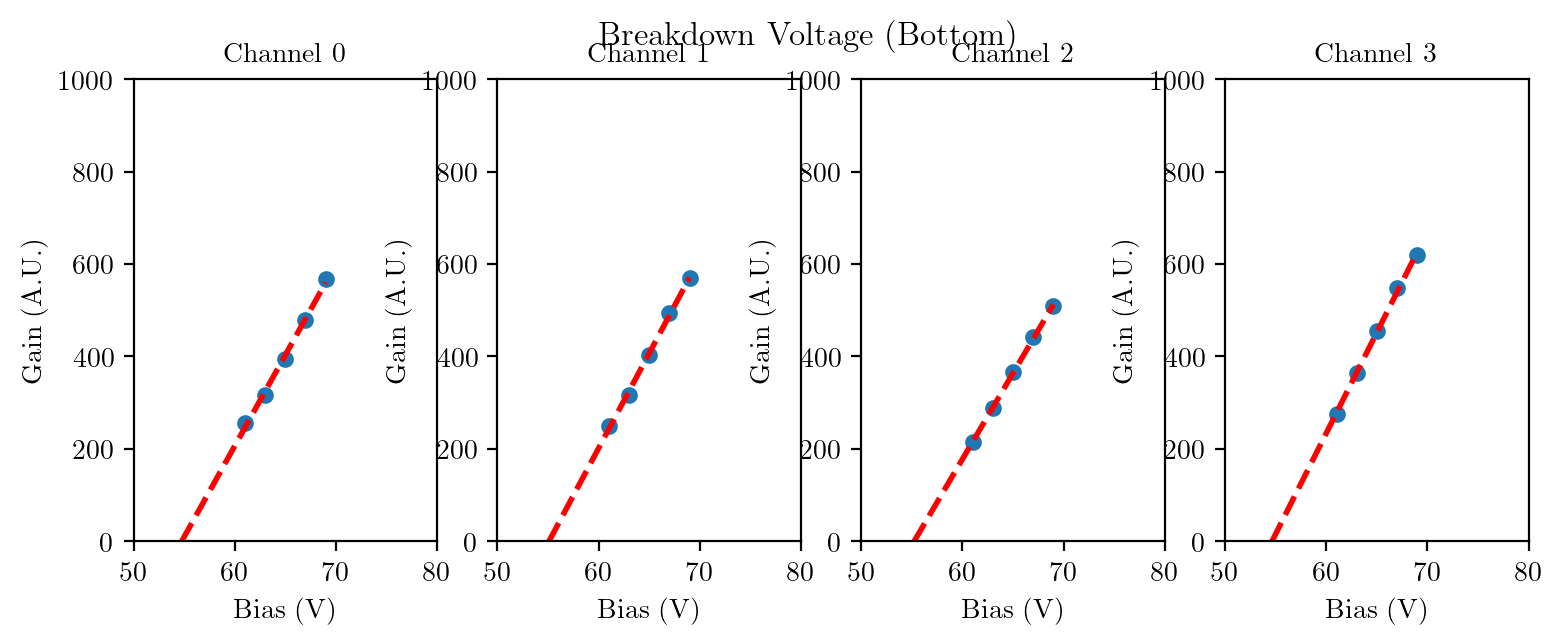

In [12]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
Vbd_charge_bottom = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets): 
        #charge histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].integral_hist, data.ch[ch].integral_hist_bin)
        plt.yscale('log')
        plt.xlim(0, 5000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        thre = 20 #threshold to remove baseline noise
        peaks,pdict = find_peaks(data.ch[ch].integral_hist[thre:], prominence=60, width=13, distance=20)
        #fit pe peaks with Gaussian
        pe_mean = []
        bin_width = data.ch[ch].integral_hist_bin[1]-data.ch[ch].integral_hist_bin[0]
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = bin_width*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = data.ch[ch].integral_hist_bin[0] + bin_width*min_bin
            max_x = data.ch[ch].integral_hist_bin[0] + bin_width*max_bin
            peak_x = data.ch[ch].integral_hist_bin[0] + bin_width*peak_bin
            popt,pcov = curve_fit(gauss, data.ch[ch].integral_hist_bin[min_bin:max_bin], data.ch[ch].integral_hist[min_bin:max_bin], p0=[data.ch[ch].integral_hist[peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(data.ch[ch].integral_hist_bin[min_bin:max_bin], gauss(data.ch[ch].integral_hist_bin[min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
            pe_mean.append(popt[1])
            if(ip==0):
                data.ch[ch].set_calibration(spe_integral=[popt[1]-2*popt[2],popt[1]+2*popt[2]])
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
        data.ch[ch].set_calibration(gain_integral=popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_integral for data in datasets]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_bottom[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)
    # calculate gain at 60V
    print('ch{} gain@60V = {}'.format(ch,line_vbd(60,popt[0],popt[1])))
        
plt.figure(0)
plt.suptitle('Charge Distribution (Bottom)')
# plt.savefig('../plots/sipm/charge_histo_bottom_0928.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Bottom)')
# plt.savefig('../plots/sipm/gain_bias_charge_bottom_0928.pdf')

## Plot filtered amplitude histogram and analyze

It seems like Ch1 has double peaks...

Channel 0 Vbd=55.276+/-0.071V slope=8.288+/-0.058
Channel 1 Vbd=55.403+/-0.127V slope=8.986+/-0.114
Channel 2 Vbd=55.034+/-0.109V slope=7.725+/-0.081
Channel 3 Vbd=55.133+/-0.098V slope=8.686+/-0.083


Text(0.5, 0.98, 'Breakdown Voltage (Bottom)')

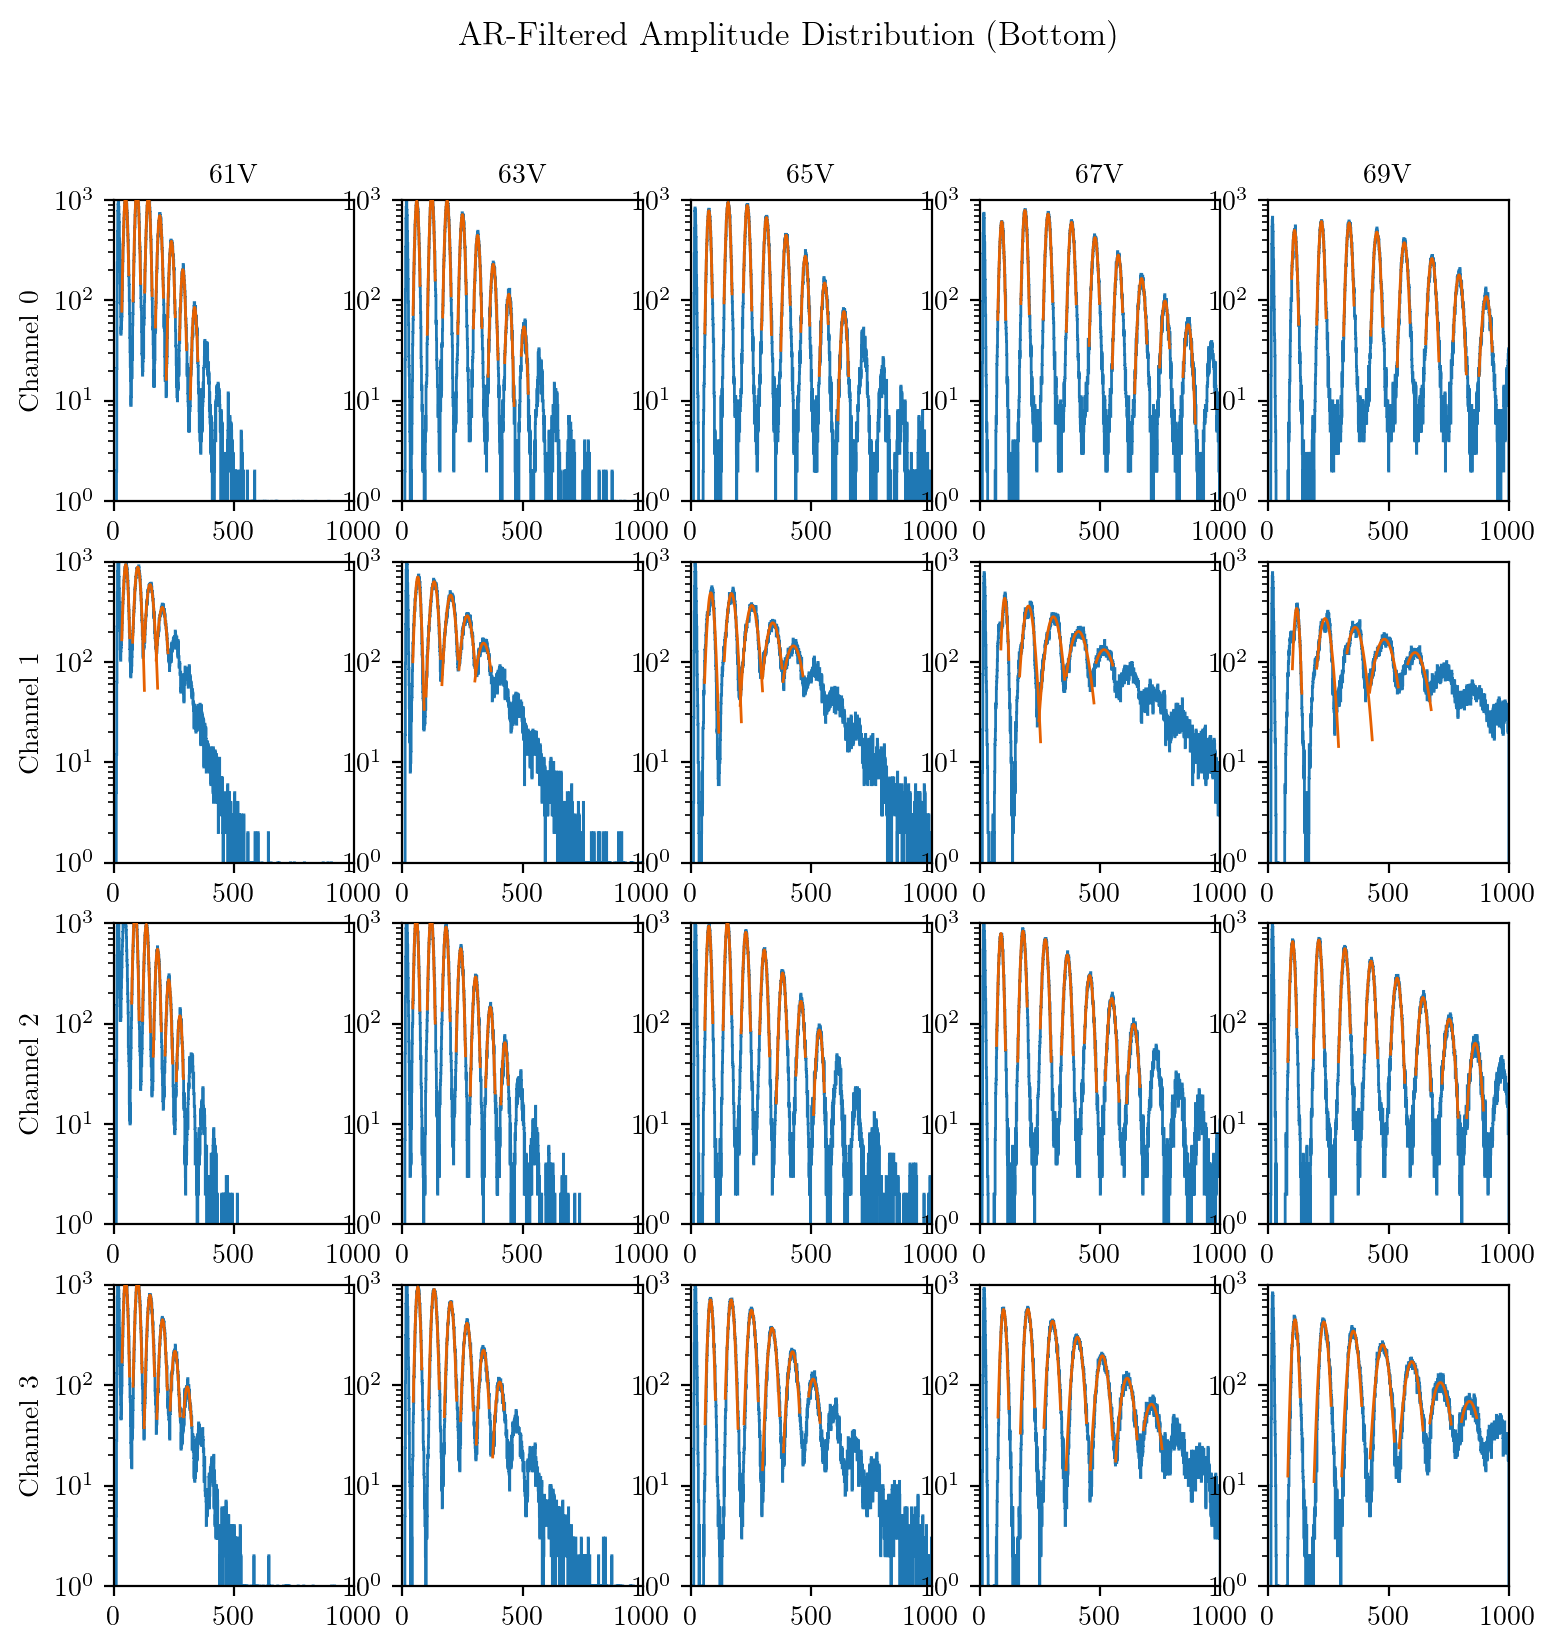

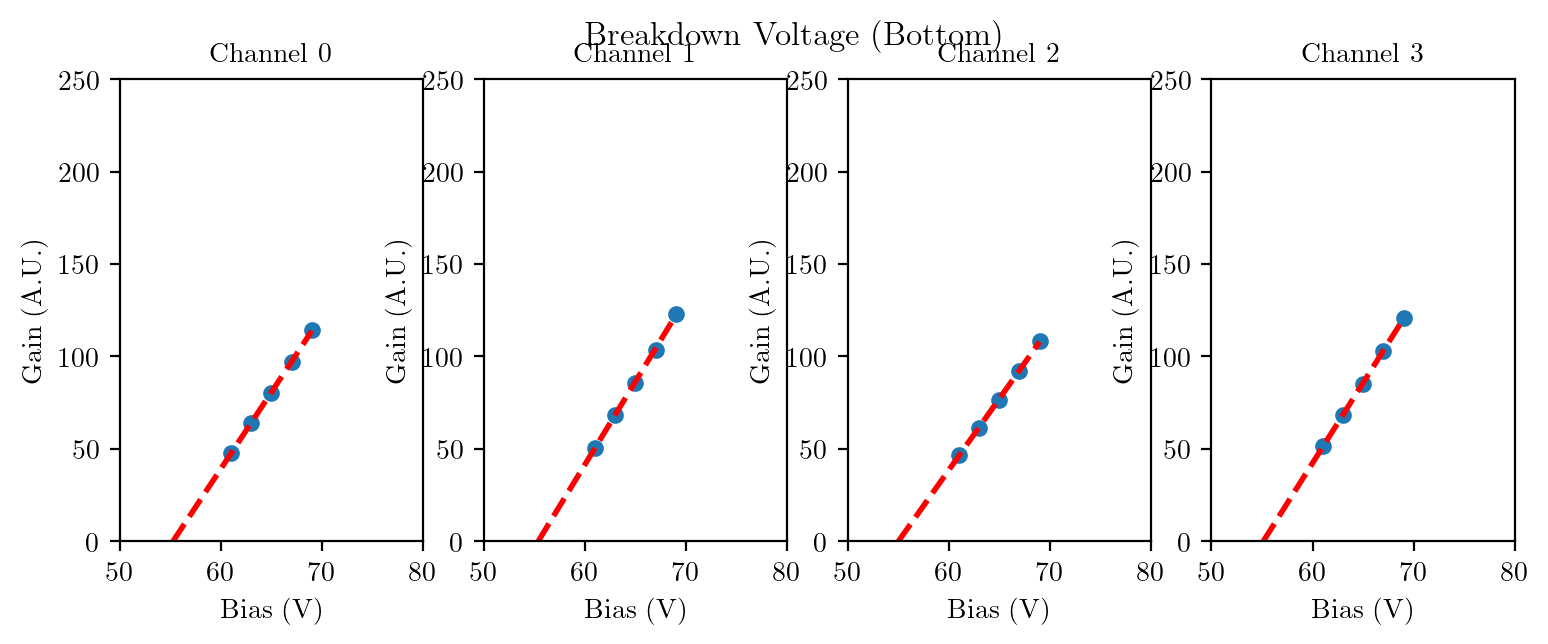

In [13]:
plt.figure(0,figsize=(9,9))#for filtered amplitude histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
Vbd_famp_bottom = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets):  
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(0, 1000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        thre = 30
        peaks,pdict = find_peaks(data.ch[ch].famp_hist[thre:], prominence=60, width=15, distance=20)
        #fit pe peaks with Gaussian
        pe_mean = []
        bin_width = data.ch[ch].famp_hist_bin[1]-data.ch[ch].famp_hist_bin[0]
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = bin_width*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = data.ch[ch].famp_hist_bin[0] + bin_width*min_bin
            max_x = data.ch[ch].famp_hist_bin[0] + bin_width*max_bin
            peak_x = data.ch[ch].famp_hist_bin[0] + bin_width*peak_bin
            popt,pcov = curve_fit(gauss, data.ch[ch].famp_hist_bin[min_bin:max_bin], data.ch[ch].famp_hist[min_bin:max_bin], p0=[data.ch[ch].famp_hist[peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(data.ch[ch].famp_hist_bin[min_bin:max_bin], gauss(data.ch[ch].famp_hist_bin[min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
            pe_mean.append(popt[1])
            if(ip==0):
                data.ch[ch].set_calibration(spe_famp=[popt[1]-2*popt[2],popt[1]+2*popt[2]])
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
        data.ch[ch].set_calibration(gain_famp=popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_famp for data in datasets]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_bottom[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Bottom)')
# plt.savefig('../plots/sipm/famp_histo_top_0928.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Bottom)')
# plt.savefig('../plots/sipm/gain_bias_famp_top_0928.pdf')

# Breakdown voltage summary

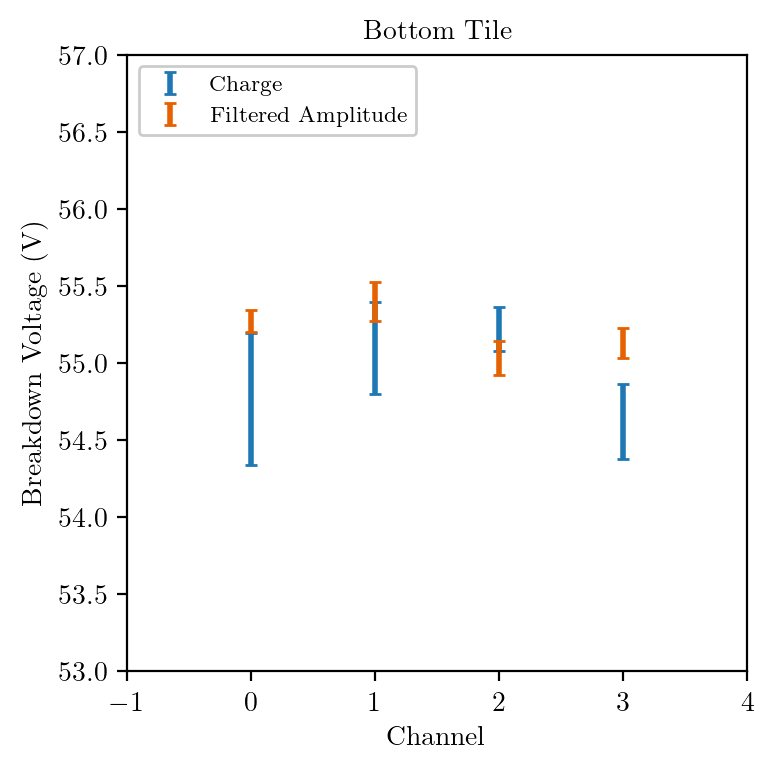

In [14]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_bottom[:,0], yerr=Vbd_charge_bottom[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_bottom[:,0], yerr=Vbd_famp_bottom[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(53,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Bottom Tile')
plt.legend()
plt.show()
# plt.savefig('../plots/sipm/vbd_bottom_0928.pdf')

## SPE average waveform

CH0 61V  A1=2.957 TAU1=0.08486us A2=0.797 TAU2=0.94820us INTEGRAL=251.768
CH0 63V  A1=3.589 TAU1=0.08105us A2=0.854 TAU2=0.97137us INTEGRAL=280.138
CH0 65V  A1=4.459 TAU1=0.07852us A2=1.081 TAU2=0.88407us INTEGRAL=326.536
CH0 67V  A1=5.713 TAU1=0.07517us A2=1.289 TAU2=0.81934us INTEGRAL=371.359
CH0 69V  A1=6.767 TAU1=0.08102us A2=1.487 TAU2=0.76660us INTEGRAL=422.131
CH1 61V  A1=3.603 TAU1=0.10215us A2=0.508 TAU2=1.26238us INTEGRAL=252.324
CH1 63V  A1=4.658 TAU1=0.10029us A2=0.620 TAU2=1.27364us INTEGRAL=314.265
CH1 65V  A1=5.908 TAU1=0.09920us A2=0.631 TAU2=1.39724us INTEGRAL=367.055
CH1 67V  A1=6.838 TAU1=0.10214us A2=0.860 TAU2=1.08353us INTEGRAL=407.556
CH1 69V  A1=7.606 TAU1=0.10269us A2=0.761 TAU2=1.29454us INTEGRAL=441.648
CH2 61V  A1=3.307 TAU1=0.08350us A2=0.498 TAU2=1.25686us INTEGRAL=225.472
CH2 63V  A1=4.141 TAU1=0.08111us A2=0.592 TAU2=1.24232us INTEGRAL=267.928
CH2 65V  A1=5.291 TAU1=0.08158us A2=0.686 TAU2=1.16771us INTEGRAL=308.146
CH2 67V  A1=6.242 TAU1=0.08043us A2=0.

Text(0.5, 0.98, 'SPE Average Waveform (Bottom)')

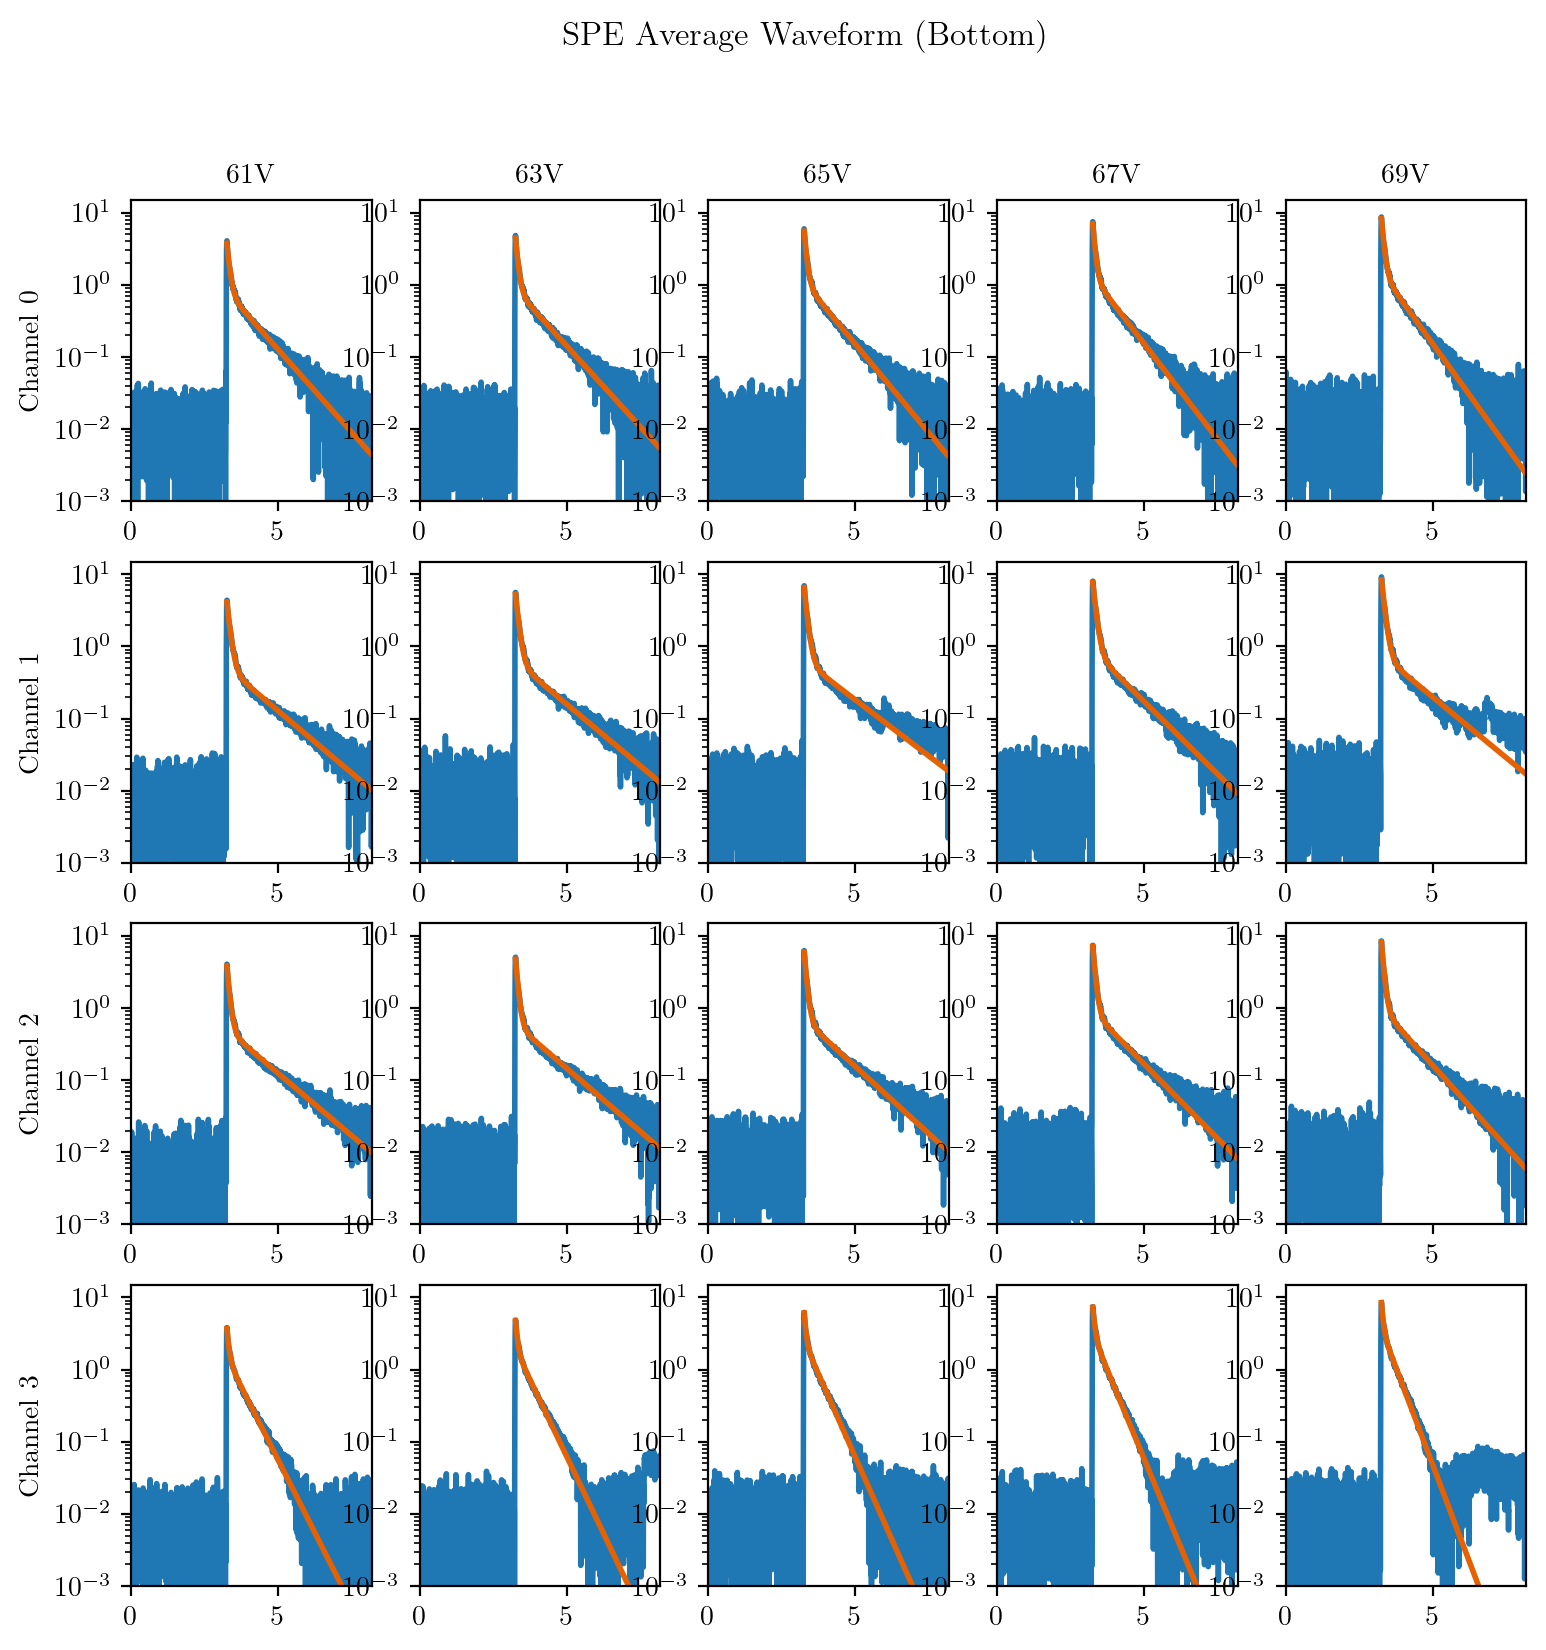

In [15]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))

for ch in [0,1,2,3]:
    for i,data in enumerate(datasets):
        data.ch[ch].get_spe_avgwf()
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(data.ch[ch].time, abs(data.ch[ch].spe_avgwf))
        popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[data.ch[ch].trigger_position:], data.ch[ch].spe_avgwf[data.ch[ch].trigger_position:], p0=[3,0.08,3,0.5],maxfev=10000)
        plt.plot(data.ch[ch].time[data.ch[ch].trigger_position:], data.ch[ch].get_pulse_shape(data.ch[ch].time[data.ch[ch].trigger_position:],*popt))
        print('CH{} {}V  A1={:.3f} TAU1={:.5f}us A2={:.3f} TAU2={:.5f}us INTEGRAL={:.3f}'.format(ch,bias[i],popt[0],popt[1],popt[2],popt[3],popt[0]*popt[1]*250+popt[2]*popt[3]*250))
        data.ch[ch].set_pulse_shape(*popt)
        plt.xlim(data.ch[ch].time[0],data.ch[ch].time[-1])
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Bottom)')
# plt.savefig('../plots/sipm/spewf_bottom_0928.pdf')